# Prepare Data for Modeling

In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [70]:
matches = pd.read_csv("/home/yassine/football_predict/R_csv/teams_final.csv")
matches.columns

Index(['Date', 'GoalDifference', 'xG_Difference', 'Season',
       'Sh_per_90_Standard', 'Sh_per_90_Standard_Away', 'HomeRank', 'AwayRank',
       'Home_Arsenal', 'Home_Aston Villa', 'Home_Bournemouth',
       'Home_Brentford', 'Home_Brighton', 'Home_Burnley', 'Home_Cardiff City',
       'Home_Chelsea', 'Home_Crystal Palace', 'Home_Everton', 'Home_Fulham',
       'Home_Huddersfield', 'Home_Leeds United', 'Home_Leicester City',
       'Home_Liverpool', 'Home_Luton Town', 'Home_Manchester City',
       'Home_Manchester Utd', 'Home_Newcastle Utd', 'Home_Norwich City',
       'Home_Nott'ham Forest', 'Home_Sheffield Utd', 'Home_Southampton',
       'Home_Stoke City', 'Home_Swansea City', 'Home_Tottenham',
       'Home_Watford', 'Home_West Brom', 'Home_West Ham', 'Home_Wolves',
       'Away_Arsenal', 'Away_Aston Villa', 'Away_Bournemouth',
       'Away_Brentford', 'Away_Brighton', 'Away_Burnley', 'Away_Cardiff City',
       'Away_Chelsea', 'Away_Crystal Palace', 'Away_Everton', 'Away_Fulham'

In [51]:
# Prepare data
X = matches.drop(columns=['GoalDifference', 'Date', 'Season'])  # Drop Date and Season from features after time-based split
y = matches['GoalDifference']

In [56]:
# Convert one-hot encoded columns to float
one_hot_cols = [col for col in X.columns if col.startswith('Home_') or col.startswith('Away_')]
X[one_hot_cols] = X[one_hot_cols].astype(float)

In [57]:
X.dtypes

xG_Difference              float64
Sh_per_90_Standard         float64
Sh_per_90_Standard_Away    float64
HomeRank                   float64
AwayRank                   float64
                            ...   
Away_Tottenham             float64
Away_Watford               float64
Away_West Brom             float64
Away_West Ham              float64
Away_Wolves                float64
Length: 65, dtype: object

In [58]:
# Time-based split
tscv = TimeSeriesSplit(n_splits=5)  # 5 splits for cross-validation
for train_index, test_index in tscv.split(matches):
    train_data, test_data = matches.iloc[train_index], matches.iloc[test_index]

X_train = train_data.drop(columns=['GoalDifference', 'Date', 'Season'])
y_train = train_data['GoalDifference']
X_test = test_data.drop(columns=['GoalDifference', 'Date', 'Season'])
y_test = test_data['GoalDifference']    

In [59]:
#Convert one hot to float after split
X_train[one_hot_cols] = X_train[one_hot_cols].astype(float)
X_test[one_hot_cols] = X_test[one_hot_cols].astype(float)

In [60]:
#Check for missing values
print(X_train.isnull().sum().any())
print(y_train.isnull().sum().any())

False
False


# Sarimax

In [65]:
import statsmodels.api as sm


# Train SARIMAX model
# p, d, q are the order of the AR, I, and MA components
# P, D, Q, s are the seasonal order and seasonal period
model = sm.tsa.SARIMAX(y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(1, 0, 0, 10)) 
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           69     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06923D+00    |proj g|=  4.51445D-03


 This problem is unconstrained.



At iterate    5    f=  1.06921D+00    |proj g|=  5.12941D-03

At iterate   10    f=  1.06920D+00    |proj g|=  1.09347D-03

At iterate   15    f=  1.06918D+00    |proj g|=  5.30172D-04

At iterate   20    f=  1.06916D+00    |proj g|=  3.34002D-03

At iterate   25    f=  1.06912D+00    |proj g|=  4.71605D-03

At iterate   30    f=  1.06910D+00    |proj g|=  2.59166D-03

At iterate   35    f=  1.06908D+00    |proj g|=  1.37034D-03

At iterate   40    f=  1.06907D+00    |proj g|=  5.83765D-04

At iterate   45    f=  1.06907D+00    |proj g|=  9.64868D-04

At iterate   50    f=  1.06907D+00    |proj g|=  8.18274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/yassine/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
print(model_fit.summary())



                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2217
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 10)   Log Likelihood               -2370.125
Date:                             Sat, 04 Jan 2025   AIC                           4878.250
Time:                                     16:00:11   BIC                           5271.820
Sample:                                          0   HQIC                          5022.009
                                            - 2217                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5753      0.018     31.708      0.000       0.540       0.611
x2            -0.0227      

In [72]:
y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)


In [73]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


RMSE: 0.8236732332780878


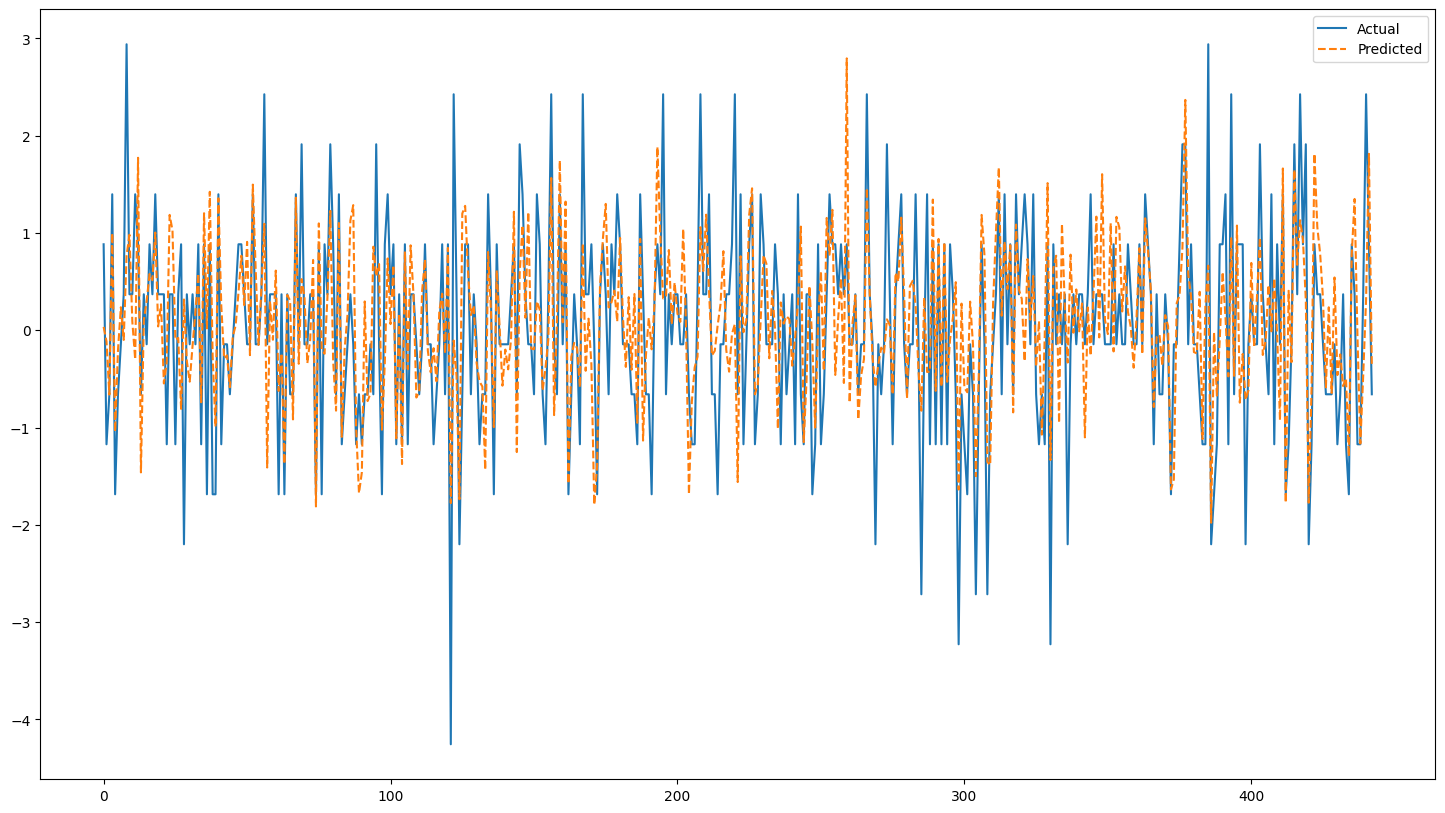

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.show()


Alignment of Predictions and Actuals:

The predicted values (orange dashed line) closely follow the actual values (blue line) for many data points, which is a good sign. This suggests the model is capturing the trend and general behavior of the data.

## Tuning the hyperparameters of Sarimax

Understand the Parameters: 
<br>

1. Order (p, d, q):<br>
p: Number of autoregressive (AR) terms (how many past values to use).<br>
d: Degree of differencing (how many times to difference the series to make it stationary).<br>
q: Number of moving average (MA) terms (how many past forecast errors to use).<br>
<br>
2. Seasonal Order (P, D, Q, s): <br>
P: Seasonal autoregressive terms.<br>
D: Seasonal differencing (to remove seasonal trends).<br>
Q: Seasonal moving average terms.<br>
s: Seasonal period (e.g., 10 for every 10 matches in your data).

We can automate the tuning using a grid search to test multiple combinations.


In [ ]:
import itertools
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Define parameter ranges for grid search (optimized for smaller ranges)
p = range(0, 5)  # AR terms
d = range(0, 2)  # Differencing
q = range(0, 3)  # MA terms
P = range(0, 2)  # Seasonal AR terms
D = range(0, 2)  # Seasonal differencing
Q = range(0, 2)  # Seasonal MA terms
s = [10]         # Seasonal period (based on data frequency)

# Generate all possible combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

# Track the best model
best_aic = float("inf")
best_params = None
best_model = None
max_epochs = 50  # Limit the number of parameter combinations to evaluate
epoch_count = 0
fail_count = 0
max_failures = 10  # Stop after 10 failures

print("Starting grid search for SARIMAX hyperparameters...")

# Perform grid search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        epoch_count += 1
        if epoch_count > max_epochs or fail_count > max_failures:
            print("Reached maximum epochs or failure limit. Stopping search.")
            break

        try:
            # Fit SARIMAX model
            model = sm.tsa.SARIMAX(y_train, exog=X_train, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            
            # Check AIC for the best model
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = (param, seasonal_param)
                best_model = model_fit

            print(f"Epoch {epoch_count}: SARIMAX{param}x{seasonal_param} - AIC: {model_fit.aic}")

        except Exception as e:
            fail_count += 1
            print(f"Epoch {epoch_count}: SARIMAX{param}x{seasonal_param} - Failed to converge. Error: {e}")
            continue

# Output the best model
if best_model:
    print(f"\nBest Model: SARIMAX{best_params[0]}x{best_params[1]} - AIC: {best_aic}")
    print("Summary of the best model:")
    print(best_model.summary())
else:
    print("No valid SARIMAX model found.")


In [79]:
# Use the best model for predictions
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Calculate performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 0.822179016254326, MAE: 0.6355158870541947


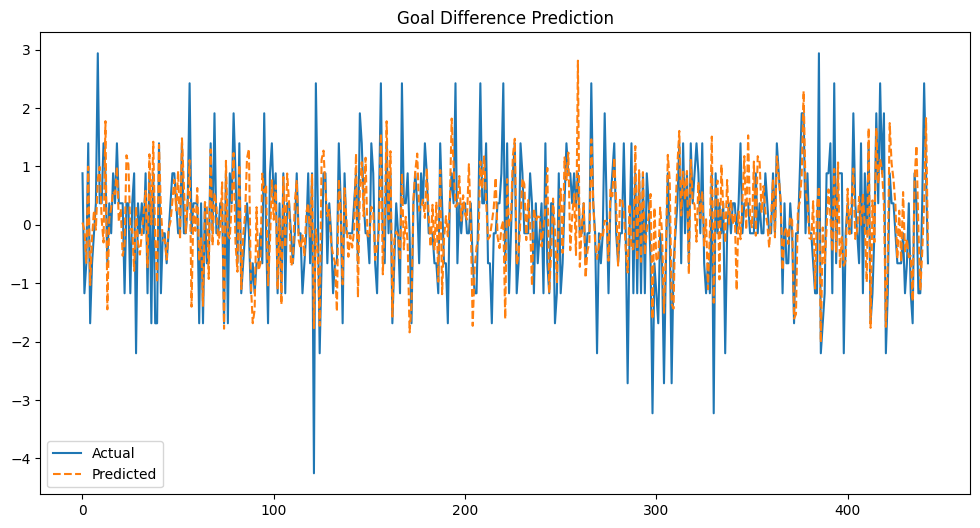

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted", linestyle='--')
plt.legend()
plt.title("Goal Difference Prediction")
plt.show()


# LSTM

In [83]:
X_train, y_train
X_test, y_test

(array([[-0.13792057, -1.2459825 ,  1.42891767, ...,  0.        ,
          0.        ,  0.        ],
        [-0.0596469 ,  0.05408544, -0.83062533, ...,  0.        ,
          0.        ,  0.        ],
        [-1.07720469, -0.11205743,  1.36661409, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.03618457, -0.26573958,  0.3822176 , ...,  0.        ,
          0.        ,  0.        ],
        [ 2.9147528 ,  3.3312535 , -0.56064317, ...,  0.        ,
          0.        ,  1.        ],
        [-0.60756263, -0.50249317, -0.28650744, ...,  0.        ,
          0.        ,  0.        ]]),
 array([ 0.88352592, -1.17217401, -0.65824903,  1.3974509 , -1.68609899,
        -0.65824903, -0.14432405,  0.36960094,  2.93922585,  0.36960094,
         0.36960094,  1.3974509 ,  0.88352592, -0.65824903,  0.36960094,
        -0.14432405,  0.88352592,  0.36960094,  1.3974509 ,  0.36960094,
         0.36960094,  0.36960094, -1.17217401,  0.36960094,  0.36960094,
        

------------------------------------------------------------------------------------------

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Data Loading (same as before)
matches = pd.read_csv("/home/yassine/football_predict/R_csv/teams_final.csv")

# 2. Feature Engineering (modified)
matches['Date'] = pd.to_datetime(matches['Date'])

matches['Week'] = matches['Date'].dt.isocalendar().week
matches['Month'] = matches['Date'].dt.month
matches['DayOfWeek'] = matches['Date'].dt.dayofweek

matches['Week_sin'] = np.sin(2 * np.pi * matches['Week'] / 52)
matches['Week_cos'] = np.cos(2 * np.pi * matches['Week'] / 52)
matches['Month_sin'] = np.sin(2 * np.pi * matches['Month'] / 12)
matches['Month_cos'] = np.cos(2 * np.pi * matches['Month'] / 12)
matches['DayOfWeek_sin'] = np.sin(2 * np.pi * matches['DayOfWeek'] / 7)
matches['DayOfWeek_cos'] = np.cos(2 * np.pi * matches['DayOfWeek'] / 7)

team_names = ['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton', 'Burnley', 'Cardiff City', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Leeds United', 'Leicester City', 'Liverpool', 'Luton Town', 'Manchester City', 'Manchester Utd', 'Newcastle Utd', 'Norwich City', 'Nott\'ham Forest', 'Sheffield Utd', 'Southampton', 'Stoke City', 'Swansea City', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wolves']

# Create HomeTeam and AwayTeam columns
for team in team_names:
    matches[f'Home_{team}'] = matches[f'Home_{team}']
    matches[f'Away_{team}'] = matches[f'Away_{team}']

def create_lags(df, feature, lags, team_names):
    lagged_df = df.copy()
    for team in team_names:
        team_df = df[df[f'Home_{team}'] == 1].copy() #Filter for Home matches for that team
        for lag in range(1, lags + 1):
            team_df[f'{feature}_lag_{lag}'] = team_df[feature].shift(lag)
        lagged_df.update(team_df)
    for team in team_names:
        team_df = df[df[f'Away_{team}'] == 1].copy() #Filter for Home matches for that team
        for lag in range(1, lags + 1):
            team_df[f'{feature}_lag_{lag}'] = team_df[feature].shift(lag)
        lagged_df.update(team_df)
    return lagged_df

features_to_lag = ['GoalDifference', 'xG_Difference', 'Sh_per_90_Standard','Sh_per_90_Standard_Away']
lags = 3

for feature in features_to_lag:
    matches = create_lags(matches, feature, lags,team_names)

matches.dropna(inplace=True)



/tmp/ipykernel_62603/3569053154.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8 8 8 ... 5 5 5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  lagged_df.update(team_df)
/tmp/ipykernel_62603/3569053154.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4 5 5 ... 6 6 6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  lagged_df.update(team_df)


In [106]:
matches.head()

,Date,GoalDifference,xG_Difference,Season,Sh_per_90_Standard,Sh_per_90_Standard_Away,HomeRank,AwayRank,Home_Arsenal,Home_Aston Villa,...,Away_Wolves,Week,Month,DayOfWeek,Week_sin,Week_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,2017-08-11,0.369601,0.566543,2018,1.233700,-0.647868,-1.450488,-1.312197,True,False,...,False,32,8,4,-0.663123,-0.748511,-0.866025,-0.5,-0.433884,-0.900969
1,2017-08-12,-0.144324,-0.607563,2018,-0.460957,1.736282,-1.307815,-1.169590,False,False,...,False,32,8,5,-0.663123,-0.748511,-0.866025,-0.5,-0.974928,-0.222521
2,2017-08-12,-1.686099,-0.529289,2018,-0.112057,-1.270904,-0.737124,-1.454804,False,False,...,False,32,8,5,-0.663123,-0.748511,-0.866025,-0.5,-0.974928,-0.222521
3,2017-08-12,0.369601,0.409995,2018,-1.083993,-0.153593,-1.165142,-0.599163,False,False,...,False,32,8,5,-0.663123,-0.748511,-0.866025,-0.5,-0.974928,-0.222521
4,2017-08-12,-0.658249,0.488269,2018,1.387382,-1.071532,-0.451779,-1.169590,False,False,...,False,32,8,5,-0.663123,-0.748511,-0.866025,-0.5,-0.974928,-0.222521


In [115]:
# 3. Feature and Target Selection
features = [col for col in matches.columns if col not in ['Date', 'GoalDifference']]
target = 'GoalDifference'

X = matches[features]
y = matches[target]

# 4. Separate Numerical and Categorical Columns (and convert to float)
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='uint8').columns

#Convert categorical to float
X[categorical_cols] = X[categorical_cols].astype(float)

# 5. Scaling ONLY Numerical Columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 6. Time Series Split
train_size = int(len(matches) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


/tmp/ipykernel_62603/1522557172.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [116]:
def reshape_data(X, timesteps):
    X_reshaped = []
    for i in range(len(X) - timesteps + 1):
        X_reshaped.append(X[i:i + timesteps])
    return np.array(X_reshaped)

timesteps = 3
X_train = reshape_data(X_train, timesteps)
X_val = reshape_data(X_val, timesteps)
X_test = reshape_data(X_test, timesteps)

y_train = y_train[timesteps-1:]
y_val = y_val[timesteps-1:]
y_test = y_test[timesteps-1:]

In [117]:
#Convert to numpy
X_train = np.array(X_train,dtype=np.float32)
X_val = np.array(X_val,dtype=np.float32)
X_test = np.array(X_test,dtype=np.float32)
y_train = np.array(y_train,dtype=np.float32)
y_val = np.array(y_val,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)

In [118]:

print("NaN values in X_train:", np.isnan(X_train).sum())
print("NaN values in y_train:", np.isnan(y_train).sum())
print("NaN values in X_test:", np.isnan(X_test).sum())
print("NaN values in y_test:", np.isnan(y_test).sum())
print("NaN values in X_val:", np.isnan(X_val).sum())
print("NaN values in y_val:", np.isnan(y_val).sum())

NaN values in X_train: 0
NaN values in y_train: 0
NaN values in X_test: 0
NaN values in y_test: 0
NaN values in X_val: 0
NaN values in y_val: 0


In [119]:
# Model Creation, Training, and Prediction
input_layer = Input(shape=(timesteps, X_train.shape[2]))  # Dynamic input shape
lstm_1 = LSTM(64, activation='relu', return_sequences=True)(input_layer)
dropout_1 = Dropout(0.2)(lstm_1)
lstm_2 = LSTM(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(lstm_2)
dense_1 = Dense(16, activation='relu')(dropout_2)
output_layer = Dense(1)(dense_1)

In [120]:
model = Model(inputs=input_layer, outputs=output_layer)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

model.compile(optimizer='adam', loss='mse')

In [121]:
from tensorflow.keras.models import load_model

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

best_model = load_model('best_model.keras')

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.0217 - val_loss: 0.9489
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8823 - val_loss: 0.7174
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6226 - val_loss: 0.6881
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5950 - val_loss: 0.6312
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5575 - val_loss: 0.6283
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5271 - val_loss: 0.6330
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4988 - val_loss: 0.6233
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4705 - val_loss: 0.6339
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5097 - val_loss: 0.6230
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4420 - val_loss: 0.6207
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4540 - val_loss: 0.6491
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [122]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Mean Squared Error on Test Set: 0.68523914


In [123]:
rmse = np.sqrt(mse) 
print("Root Mean Squared Error on Test Set:", rmse)


Root Mean Squared Error on Test Set: 0.82779175


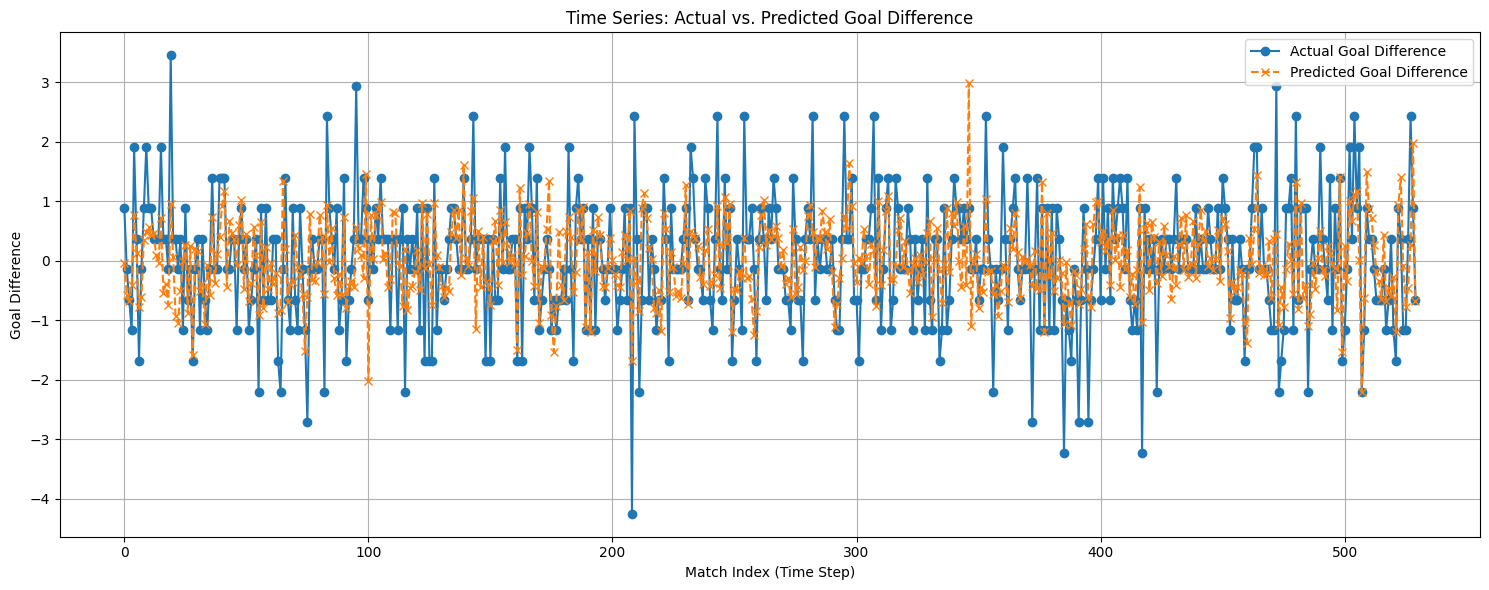

In [125]:
# Time Series Plot
plt.figure(figsize=(15, 6))
plt.plot(y_test, label="Actual Goal Difference", marker='o', linestyle='-')
plt.plot(y_pred, label="Predicted Goal Difference", marker='x', linestyle='--')
plt.xlabel("Match Index (Time Step)")
plt.ylabel("Goal Difference")
plt.title("Time Series: Actual vs. Predicted Goal Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The model captures the general trend of goal differences but struggles with the magnitude of extreme values (peaks and troughs), often underestimating them. Predictions appear smoothed compared to the actual data, with a possible slight phase shift (delay) observed in some sections, indicating room for improvement in accuracy.

Let's try different parameters now in hope to reduce the error 

In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import ParameterGrid

# ... (Data loading, feature engineering, splitting, reshaping as before)

param_grid = {
    'lstm_units_1': [32, 64],  # Reduced range
    'lstm_units_2': [16, 32],  # Reduced range
    'dropout_rate': [0.1, 0.2],  # Reduced range
    'batch_size': [32, 64],    # Reduced range
    'epochs':[20] #reduced epochs
}

grid = ParameterGrid(param_grid)

best_rmse = float('inf')
best_params = {}

for params in grid:
    print(f"Testing parameters: {params}")

    input_layer = Input(shape=(timesteps, X_train.shape[2]))
    lstm_1 = LSTM(params['lstm_units_1'], activation='relu', return_sequences=True)(input_layer)
    dropout_1 = Dropout(params['dropout_rate'])(lstm_1)
    lstm_2 = LSTM(params['lstm_units_2'], activation='relu')(dropout_1)
    dropout_2 = Dropout(params['dropout_rate'])(lstm_2)
    dense_1 = Dense(16, activation='relu')(dropout_2)
    output_layer = Dense(1)(dense_1)

    model = Model(inputs=input_layer, outputs=output_layer)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience
    model_checkpoint = ModelCheckpoint(filepath='temp_model.keras', monitor='val_loss', save_best_only=True)

    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint], verbose=0)

    best_model = load_model('temp_model.keras')
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        model.save("best_model.keras")

print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units_1': 32, 'lstm_units_2': 16}
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units_1': 32, 'lstm_units_2': 32}
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units_1': 64, 'lstm_units_2': 16}
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units_1': 64, 'lstm_units_2': 32}
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units_1': 32, 'lstm_units_2': 16}
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units_1': 32, 'lstm_units_2': 32}
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'l

Best Parameters: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units_1': 64, 'lstm_units_2': 32}
But the Rmse we generated earlier is better then "Best RMSE: 0.8296537399291992" 


## Adding extra attention layer and Hubber_loss

In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf

In [128]:
def create_model(timesteps, features):
    input_layer = Input(shape=(timesteps, features))
    lstm_1 = LSTM(64, activation='relu', return_sequences=True)(input_layer)
    dropout_1 = Dropout(0.2)(lstm_1)
    lstm_2 = LSTM(32, activation='relu', return_sequences=True)(dropout_1)
    attention_layer = Attention()([lstm_2, lstm_2])  # Self-attention
    flatten = Flatten()(attention_layer)
    dropout_2 = Dropout(0.2)(flatten)
    dense_1 = Dense(16, activation='relu')(dropout_2)
    output_layer = Dense(1)(dense_1)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [129]:
# Huber Loss
def huber_loss(y_true, y_pred, delta=1.0):
    residual = tf.abs(y_true - y_pred)
    condition = tf.less(residual, delta)
    squared_loss = 0.5 * tf.square(residual)
    linear_loss = delta * (residual - 0.5 * delta)
    return tf.where(condition, squared_loss, linear_loss)

In [130]:
#Quantile Loss
def quantile_loss(y_true, y_pred, quantile):
    err = y_true - y_pred
    return tf.reduce_mean(tf.where(err > 0, quantile * err, (quantile - 1) * err))

In [131]:
timesteps = 3
model = create_model(timesteps, X_train.shape[2])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

# Compile with Huber Loss
model.compile(optimizer='adam', loss=lambda y_true, y_pred: huber_loss(y_true, y_pred, delta=1.0))


In [132]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3946 - val_loss: 0.4013
Epoch 2/100
17/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4419

/home/yassine/miniconda3/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(optimizer='adam', loss=lambda y_true, y_pred: huber_loss(y_true, y_pred, delta=1.0))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4161 - val_loss: 0.3995
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3962 - val_loss: 0.3834
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3555 - val_loss: 0.3060
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2741 - val_loss: 0.2962
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2635 - val_loss: 0.2972
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2397 - val_loss: 0.2965
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2356 - val_loss: 0.2906
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2312 - val_loss: 0.2947
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2219 - val_loss: 0.3003
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2151 - val_loss: 0.2908
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1966 - val_loss: 0.2972
Epoch 13/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2024 - val_l

In [134]:
best_model = load_model('best_model.keras',safe_mode=False)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE on Test Data: {rmse}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
RMSE on Test Data: 0.855880618095398


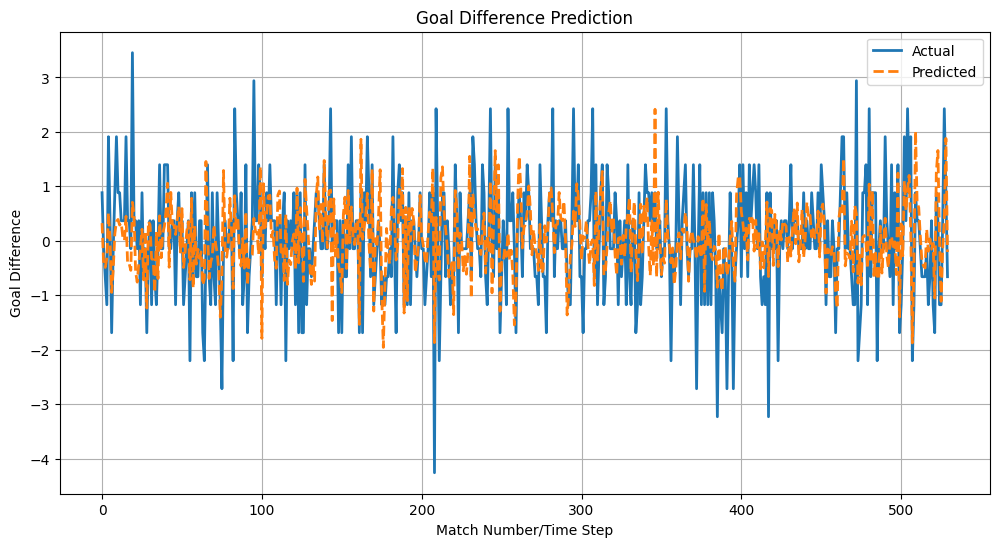

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title('Goal Difference Prediction')
plt.xlabel('Match Number/Time Step')
plt.ylabel('Goal Difference')
plt.legend()
plt.grid(True)
plt.show()

# Transformer model

In [172]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def create_enhanced_transformer_model(timesteps, features):
    input_layer = Input(shape=(timesteps, features), name="input_layer")
    
    # Transformer Encoder Block
    attention_output = MultiHeadAttention(
        num_heads=8, key_dim=features, dropout=0.3
    )(input_layer, input_layer)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    attention_output = tf.keras.layers.Add()([input_layer, attention_output])  # Residual Connection
    
    # Feedforward Network
    feedforward_output = Dense(
        256, activation="relu", kernel_regularizer=l2(0.01)
    )(attention_output)
    feedforward_output = Dense(
        features, kernel_regularizer=l2(0.01)
    )(feedforward_output)  # Project back to original feature size
    feedforward_output = Dropout(0.3)(feedforward_output)
    feedforward_output = LayerNormalization(epsilon=1e-6)(feedforward_output)
    transformer_output = tf.keras.layers.Add()(
        [attention_output, feedforward_output]
    )  # Residual Connection
    
    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)
    
    # Dense Layers
    dense_1 = Dense(
        128, activation="relu", kernel_regularizer=l2(0.01)
    )(pooled_output)
    dropout_1 = Dropout(0.3)(dense_1)
    dense_2 = Dense(
        64, activation="relu", kernel_regularizer=l2(0.01)
    )(dropout_1)
    dropout_2 = Dropout(0.3)(dense_2)
    output_layer = Dense(1)(dropout_2)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [176]:
# Assuming your time series data has timesteps=3 and features=75
timesteps = 3
features = 75  # Replace with X_train.shape[2]

# Create the model
model = create_enhanced_transformer_model(timesteps, features)

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), 
    epochs=50, batch_size=32, callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )
    ]
)


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3, 75)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 75)     │    181,875 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 75)     │        150 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 3, 75)     │          0 │ input_layer[0][0… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 3, 256)    │     19,456 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 3, 75)     │     19,275 │ dense_60[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 3, 75)     │          0 │ dense_61[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 75)     │        150 │ dropout_58[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 3, 75)     │          0 │ add_10[0][0],     │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 75)        │          0 │ add_11[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │      9,728 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 128)       │          0 │ dense_62[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 64)        │      8,256 │ dropout_59[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 64)        │          0 │ dense_63[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 1)         │         65 │ dropout_60[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 238,955 (933.42 KB)

 Trainable params: 238,955 (933.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 5.6653 - mae: 1.0053 - val_loss: 4.7265 - val_mae: 0.7948
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.4896 - mae: 0.7646 - val_loss: 4.1697 - val_mae: 0.7787
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9247 - mae: 0.7449 - val_loss: 3.6605 - val_mae: 0.7556
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.4859 - mae: 0.7504 - val_loss: 3.2047 - val_mae: 0.7562
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ -0s -3768us/step - loss: 2.9844 - mae: 0.7265 - val_loss: 2.8276 - val_mae: 0.7591
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.6369 - mae: 0.7219 - val_loss: 2.5561 - val_mae: 0.7764
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4233 - mae: 0.7469 - val_loss: 2.2521 - val_mae: 0.7548
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.0596 - mae: 0.7159 - val_loss: 2.0278 - val_mae: 0.7573
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1

In [177]:
# Generate predictions on the test data
y_pred = model.predict(X_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [178]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse:.4f}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae:.4f}")


Root Mean Squared Error (RMSE) on Test Data: 1.0052
Mean Absolute Error (MAE) on Test Data: 0.7798


/home/yassine/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [179]:
# Optional: Compare a few actual vs predicted values
import pandas as pd

comparison_df = pd.DataFrame({
    "Actual": y_test.flatten(),
    "Predicted": y_pred.flatten()
})

print(comparison_df.head(10))  # Display the first 10 comparisons

     Actual  Predicted
0  0.883526   0.681811
1 -0.144324  -0.072847
2 -0.658249   0.036828
3 -1.172174  -0.535910
4  1.911376  -0.014374
5  0.369601   0.096478
6 -1.686099  -0.071565
7 -0.144324  -1.347906
8  0.883526   0.067694
9  1.911376   0.587288


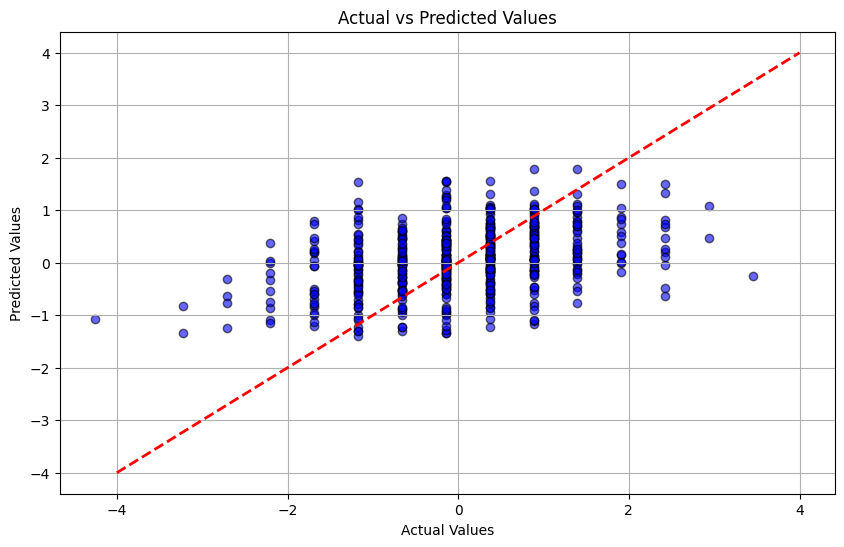

In [181]:
# Scatter plot for actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", edgecolor="k")
plt.plot([-4, 4], [-4, 4], color="red", linestyle="--", linewidth=2)  # Reference line (perfect prediction)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


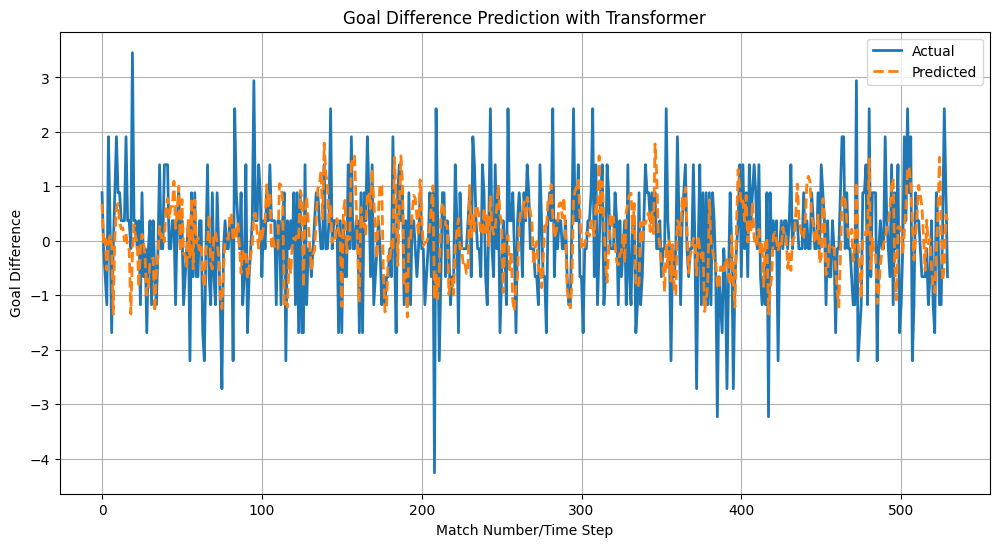

In [182]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title('Goal Difference Prediction with Transformer')
plt.xlabel('Match Number/Time Step')
plt.ylabel('Goal Difference')
plt.legend()
plt.grid(True)
plt.show()
